In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
!unzip /content/drive/MyDrive/Dataset/malignant\ vs\ benign/data.zip

In [4]:
import os
import cv2
import keras
import numpy as np
import pandas as pd
import random as rn
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import SVG
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import gc
from keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.python.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
from tensorflow.python.keras.utils.vis_utils import model_to_dot
from tensorflow.python.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception

from tensorflow.keras.applications.mobilenet import MobileNet

from sklearn.model_selection import train_test_split,KFold, cross_val_score, GridSearchCV
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array, save_img
from tensorflow.python.keras.layers import Dense, Flatten,MaxPooling2D, GlobalAveragePooling2D,BatchNormalization,Dropout,Conv2D,MaxPool2D
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from keras.utils.vis_utils import plot_model

In [5]:
train_data_dir='/content/data/train'
test_data_dir='/content/data/test'

In [6]:
img_height= 224
img_width = 224
batch_size= 64

train_datagen=ImageDataGenerator(rescale=1./255,
                                 zoom_range=0.1,
                                 validation_split=0.1)

train_generator=train_datagen.flow_from_directory(
  train_data_dir,
  target_size=(img_height,img_width),
  class_mode='binary',
  batch_size=batch_size,
  subset='training'  
)

validation_generator=train_datagen.flow_from_directory(
  train_data_dir,
  target_size=(img_height,img_width),
  class_mode='binary',
  batch_size=batch_size,
  subset='validation'  
)

test_datagen=ImageDataGenerator(rescale=1./255)

test_generator=test_datagen.flow_from_directory(
  train_data_dir,
  target_size=(img_height,img_width),
  class_mode='binary',
  batch_size=batch_size,
  shuffle=False
)


Found 2374 images belonging to 2 classes.
Found 263 images belonging to 2 classes.
Found 2637 images belonging to 2 classes.


(224, 224, 3)


<function matplotlib.pyplot.show>

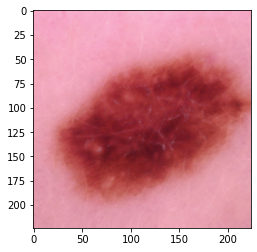

In [7]:
x,y=next(train_generator)
print(x[0].shape)
plt.imshow(x[0,:,:,:])
plt.show

In [8]:
epochs=50
model=Sequential()

pretrained_model=InceptionV3(include_top=False,
                             input_shape=(224, 224, 3),
                             pooling='avg',
                             weights='imagenet')

print(len(pretrained_model.layers))


for layer in pretrained_model.layers:
  if(isinstance(layer,tf.keras.layers.BatchNormalization)):
    layer.trainable=True

model.add(pretrained_model)
model.add(Flatten())

model.add(Dense(512,activation='relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())

model.add(Dense(256,activation='relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())

model.add(Dense(1,activation='sigmoid'))
model.summary()


87916544/87910968 [==============================] - 1s 0us/step
312
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
batch_normalization_94 (Batc (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_____________________________________________________

In [9]:
model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])
red_lr=ReduceLROnPlateau(monitor='val_loss',patience=3,verbose=1,factor=0.7)
early_bird=EarlyStopping(monitor='accuracy',patience=10)
path=f'/content/drive/MyDrive/projects/Malign_vs_Benign/model.h5'
checkpoint=ModelCheckpoint(path,monitor='val_loss',verbose=1,mode='min',save_weights_only=False,save_best_only=True)

In [10]:
# Training (Fitting)

history=model.fit_generator(train_generator,
                            steps_per_epoch=train_generator.samples // batch_size,
                            validation_data=validation_generator,
                            validation_steps = validation_generator.samples // batch_size,
                            epochs = epochs,
                            verbose = 1,
                            callbacks=[early_bird,checkpoint,red_lr])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
37/37 [==============================] - 79s 991ms/step - loss: 0.6674 - accuracy: 0.6906 - val_loss: 211639.0625 - val_accuracy: 0.5430

Epoch 00001: val_loss improved from inf to 211639.06250, saving model to /content/drive/MyDrive/projects/Malign_vs_Benign/model.h5
Epoch 2/50
37/37 [==============================] - 34s 922ms/step - loss: 0.4280 - accuracy: 0.8059 - val_loss: 11548.3965 - val_accuracy: 0.5391

Epoch 00002: val_loss improved from 211639.06250 to 11548.39648, saving model to /content/drive/MyDrive/projects/Malign_vs_Benign/model.h5
Epoch 3/50
37/37 [==============================] - 35s 932ms/step - loss: 0.3411 - accuracy: 0.8522 - val_loss: 7.4523 - val_accuracy: 0.5469

Epoch 00003: val_loss improved from 11548.39648 to 7.45235, saving model to /content/drive/MyDrive/projects/Malign_vs_Benign/model.h5
Epoch 4/50
37/37 [==============================] - 35s 935ms/step - loss: 0.3653 - accuracy: 0.8193 - val_loss: 0.6787 - val_accuracy: 0.5469

Epoch 00004

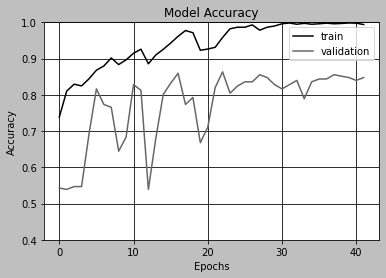

In [14]:
import matplotlib.pyplot as plt
plt.style.use('grayscale')
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis( ymin= 0.4, ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()
fig1.savefig(f'/content/drive/MyDrive/projects/Malign_vs_Benign/Accuracy.jpg')


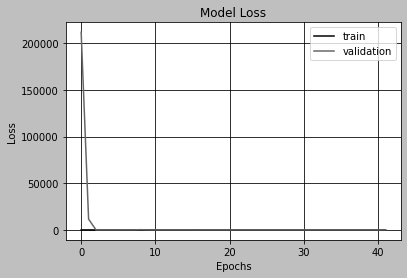

In [17]:
fig1 = plt.gcf()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')

plt.legend(['train', 'validation'])
plt.show()
fig1.savefig(f'/content/drive/MyDrive/projects/Malign_vs_Benign/loss.jpg')


In [19]:
Y_pred = model.predict(test_generator)
y_pred=[]
for i in range(len(Y_pred)):
    if Y_pred[i][0]>0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)
print('Confusion Matrix')
print(metrics.confusion_matrix(test_generator.classes, y_pred))
print ()

print('Classification Report')
target_names = ['benign', 'malignant']
print(metrics.classification_report(test_generator.classes, y_pred, target_names=target_names))

print(test_generator.class_indices)

Confusion Matrix
[[1427   13]
 [  30 1167]]

Classification Report
              precision    recall  f1-score   support

      benign       0.98      0.99      0.99      1440
   malignant       0.99      0.97      0.98      1197

    accuracy                           0.98      2637
   macro avg       0.98      0.98      0.98      2637
weighted avg       0.98      0.98      0.98      2637

{'benign': 0, 'malignant': 1}


In [21]:
import os
os.chdir("/content/drive/My Drive/projects/Malign_vs_Benign/")
model.save('inceptionv3_Benign_Malign.h5')


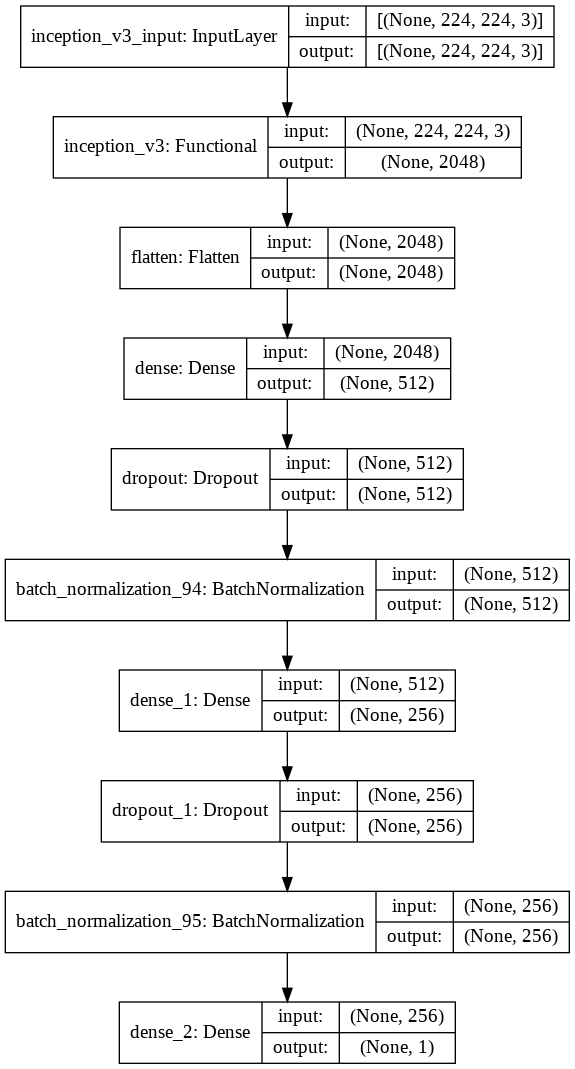

In [22]:
plot_model(model, to_file='/content/drive/My Drive/projects/Malign_vs_Benign/model_plot.png', show_shapes=True, show_layer_names=True, )

/content/drive/My Drive/projects/Malign_vs_Benign/Confusion Matrix without Normalization


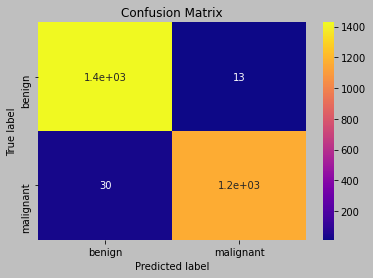

Confusion Matrix with Normalized Values


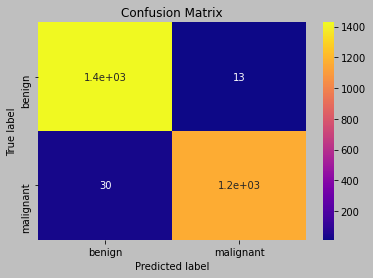

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
def plot_confusion_matrix(normalize):
    classes = ['benign', 'malignant']
    tick_marks = [0.5,1.5]
    cn = confusion_matrix(test_generator.classes, y_pred)
    sns.heatmap(cn,cmap='plasma',annot=True)
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

print('/content/drive/My Drive/projects/Malign_vs_Benign/Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)
plt.savefig('/content/drive/My Drive/projects/Malign_vs_Benign/Confusion Matrix without NormalizationConfusion Matrix without Normalization.png')


print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')